# CSCI 3202, Spring 2018

# Friday 16 March 2018

# In-class notebook:  Bayesian networks

<a id='top'></a>

<br>

### Your name(s):

<br>

You **are not** submitting this to Moodle as a Quizlet.

---

Shortcuts:  [Top](#top) || [BayesNode](#node) | [Probabilities](#probs) | [Sidewalk](#sidewalk) | [Approx. Inference](#approx) | [Cond. Probs.](#conditional) || [Conclusions](#conclusions)

---

Before we begin, let's load a few packages that we might find useful.

In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
### Class for nodes in a Bayesian network

Below defines a class `BayesNode`, which will store everything we need for a discrete node state in a Bayesian network (Bayes net).

The constructor requires 3 arguments:
* `name` is a string for the variable name
* `parents` is a list of strings representing the names of the parent variables
* `cpt` is a dictionary where the keys are tuples representing parent state values and the dict values are the resulting probabilities of this variable.
  * If this variable has no parents, then the key should be an empty tuple.
  * And recall that it is only necessary to store the probability of `True` for a Boolean variable. In general, we must store the number of possible values minus 1 for any discrete variable state.
  
And if you are curious, that `__repr__` method is defined so that Python returns some reasonable-looking output when we print a `BayesNode` object to screen. (more on this later)

In [2]:
class BayesNode:
    
    def __init__(self, name, parents, cpt):
        if isinstance(parents, str):
            parents = parents.split()
            
        if len(parents)==0:
            # if no parents, empty tuple dict key for cpt
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # if there is only one parent, only one tuple argument
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v): p for v, p in cpt.items()}

        self.variable = name
        self.parents = parents
        self.cpt = cpt
        self.children = []
        
    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))

Since we are only dealing with Boolean variables in this exercise, for brevity's sake we can define `T` and `F` to represent our typical truth values.  But note that here and in other Boolean Bayes net applications, we will frequently use $+x$ to denote the event $X=\text{True}$ and $-x$ for the event $X=\text{False}$.

In [3]:
T = True
F = False

---
### Calculating probabilities from the `BayesNode` objects

Here is a helpful function to calculate the probability of seeing Boolean `BayesNode` variable `var==value`, when the parents' values are given in `evidence`.

In [4]:
def P(var, value, evidence={}):
    '''The probability distribution for P(var | evidence), 
    when all parent variables are known (in evidence) and
    we have Boolean variables'''
    if len(var.parents)==1:
        # only one parent
        row = evidence[var.parents[0]]
    else:
        # multiple parents
        row = tuple(evidence[parent] for parent in var.parents)
    return var.cpt[row] if value else 1-var.cpt[row]

Let's use this machinery to calculate a probability from a hopefully familiar Bayesian network. Consider the Bayes net for falling on the sidewalk outside your house, from the Quizlet 9:

# todo - insert image here


Use the `BayesNode` class to create node objects for each of `Shoes`, `Icy` and `Fall`. The first one is done for you. 

In [5]:
Shoes = BayesNode('Shoes', '', 0.5)

# Solution:
Icy = BayesNode('Icy', '', 0.1)
Fall = BayesNode('Fall', ['Shoes', 'Icy'], {(T,T) : 0.4, (T,F) : 0.7, (F,T) : 0.1, (F,F) : 0.01})

---
### A short detour:  printable representations in Python

If you are not sure what exactly that `__repr__` method is doing, let's find out!  Try printing to the screen the `Shoes` object.

In [6]:
print(Shoes)

('Shoes', '')


Now, go back to the `BayesNode` class and comment out the `__repr__` method.  Then, redefine your `Shoes` object using the slightly revised `BayesNode` class.  Finally, let's see how this affects the output when we print `Shoes`:

In [7]:
print(Shoes)

('Shoes', '')


**BLECH!** That's what we like the modifiable representation of our objects. Go change it back and redefine the `BayesNode` class and the `Shoes` node!

**The point:**  You can add and/or modify that `__repr__` method for any class you define, which gives some nice flexibility in interpreting output, and potentially for debugging.

---

### Back to our jokester roommate and icy sidewalk

Check a few probabilities to make sure you know how the `P` function works.  One example is given as an `assert` statement below, but it's worthwhile to check some of the other ones, including checking if a variable is `False`.

In [8]:
assert P(Fall, T, {'Shoes' : F, 'Icy' : T})==0.1, "Something has gone wrong!"

Now let's use the function `P` to calculate the probability of falling down on any given day as you leave your house.

As you saw on the Quizlet,

$$\begin{align*}
  P(F) &= \sum_{s,c} P(F \mid s, c) P(s,c) \\
       &= \sum_s \sum_c P(F \mid s,c) P(s) P(c) \\
       &= \sum_s P(s) \sum_c P(F \mid s,c) P(c) \\
  \end{align*}$$
  
Check this calculation using the nodes you defined above and the `P` function. Recall that $P(+f) = 0.3445$.

In [9]:
p_true = (P(Shoes, T)*(P(Fall, T, {'Shoes' : T, 'Icy' : T})*P(Icy, T) +
                       P(Fall, T, {'Shoes' : T, 'Icy' : F})*P(Icy, F)) +
          P(Shoes, F)*(P(Fall, T, {'Shoes' : F, 'Icy' : T})*P(Icy, T) + 
                       P(Fall, T, {'Shoes' : F, 'Icy' : F})*P(Icy, F)))

p_false = (P(Shoes, T)*(P(Fall, F, {'Shoes' : T, 'Icy' : T})*P(Icy, T) +
                        P(Fall, F, {'Shoes' : T, 'Icy' : F})*P(Icy, F)) + 
           P(Shoes, F)*(P(Fall, F, {'Shoes' : F, 'Icy' : T})*P(Icy, T) + 
                        P(Fall, F, {'Shoes' : F, 'Icy' : F})*P(Icy, F)))

print('P(+f) = {:0.4f}'.format(p_true))

P(+f) = 0.3445


---
# Approximate inference

The algorithm:

1. For each $X_i$ in $X_1, X_2, \ldots , X_{n-1}, X_n$:
  1. Draw a sample from $P(X_i \mid \text{parents}(X_i))$ (it's nice to be vectorized, if possible)
  1. If $X_i$ has no parents, then draw from the **prior** distribution, $P(X_i)$
1. Draw large samples for each variable all at once, or do this many, many times.
  
Let's suppose we have a node ordering of `Shoes`, `Icy`, `Fall`.

The first step is then to draw a sample from $P(\text{Shoes})$.  Let's make a sample of size 10000.

In [10]:
n_sample = 10000
sample_shoes = np.random.choice([T,F], size=n_sample, p=[P(Shoes, T), 1-P(Shoes, T)])

Now with a bit of foresight, we realize that we will quickly have a lot of arrays and lists flying around with variable-specific names!  Especially when both `sample_icy` and `sample_shoes` are going to be pretty much the same thing, which is `n_sample` random draws from some distribution.

So instead of having a bunch of separate arrays, we can store all these samples for our approximate Bayesian computation in a Pandas DataFrame.  We can convert our `sample_shoes` array into a DataFrame using the following command.  It will place our array `sample_shoes` as a column in the DataFrame with the title we give it.  "Shoes" seems like a reasonable title.

In [11]:
dfSample = pd.DataFrame({'Shoes' : sample_shoes})

The second step: we move on to the next varable, `Icy`.  We draw a sample of `n_sample` realizations from this variable's distribution too, conditioned on the previous variables.  But the two are independent, so we are sampling from the prior $P(\text{Icy})$, similar to our sample for `Shoes`.  We can store this straightaway as a new column of our DataFrame:

In [12]:
dfSample['Icy'] = np.random.choice([T,F], size=n_sample, p=[P(Icy, T), 1-P(Icy, T)])

If you haven't used Pandas DataFrames before, you might be wondering why the heck we're going through this trouble. Turns out they have some nice features. For example, you can calculate the mean of each column quickly:

In [13]:
dfSample.mean()

Shoes    0.5011
Icy      0.0945
dtype: float64

Or plot histograms of the columns:

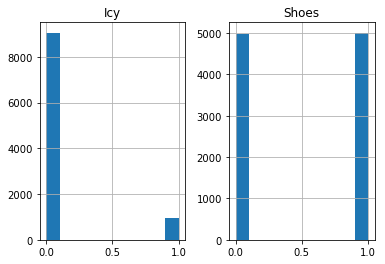

In [14]:
dfSample.hist()
plt.show()

**Question:** Do the results for the mean and histograms of our `Shoes` and `Icy` samples match what we expect from their prior distributions?

Okay, now we need to sample from the conditional distribution of `Fall`, given the values of `Shoes` and `Icy` that we sampled. We put our previous samples into a DataFrame to make it easier to keep track of which samples from the priors (causes) lead to which samples from the effects variables (like `Fall`).

Each row in `dfSample` corresponds to a different sample from the prior distributions of `Shoes` and `Icy`. So we need to `apply` to each row of `dfSample` a function to draw a sample for `Fall` from the conditional distribution $P(\text{Fall} \mid \text{Shoes, Icy})$, where the values for `Shoes` and `Icy` are brought in from the first two columns of `dfSample`.

Define a function `sample_2parent(row, variable, parents)` that takes three arguments
* `row`, a given row of the DataFrame `dfSample`
* `variable`, a `BayesNode` object whose conditional probability we want to sample from
* `parents`, a list of variable names (strings) that give the parents of the variable we want to sample. As the name suggests, you may assume there are two parents.

`sample_2parent` should return a random sample from the conditional probability distribution of `variable`, given the values in the given `row` of its `parents`.

In [15]:
# Solution:

def sample_2parent(row, variable, parents):
    return np.random.choice([T,F], p=[P(variable, T, {parents[0]: row[parents[0]], parents[1]: row[parents[1]]}), 
                                      P(variable, F, {parents[0]: row[parents[0]], parents[1] : row[parents[1]]})])

Now we can use the Pandas `apply` method to apply this function to each row of our sample DataFrame:

In [16]:
dfSample['Fall'] = dfSample.apply(sample_2parent, axis=1, variable=Fall, parents=Fall.parents)

Let's check what is the marginal probability of falling outside our house, $P(\text{Fall})$:

In [17]:
dfSample['Fall'].sum()/n_sample

0.34699999999999998

**Question:** Does that match what you expect based on the Quizlet calculation?

The above is what we call **prior sampling**.  That is, we draw from the variables' prior distributions, and use that information to "trickle down" our sampling through the Bayes net. These probabilities (samples) propagate by using the conditional probabilities that link from causes to effects, the way the samples for `Fall` were conditioned on our previous samples for `Shoes` and `Icy`.

We can evaluate **joint probabilities** of events by looking at how many samples satisfy those events, out of the total number of samples.

**Question:** For example, what is the joint probability of your shoes were tied together, your sidewalk was not icy, and you did not fall down?  That is, what is our estimate of $P(+s, -i, -f)$?

Below is a snippet of code to extract only the rows of `dfSample` that match these criteria.  You will need to modify this in order to estimate $P(+s, -i, -f)$. You should get about 0.1343.

In [18]:
dfSample.loc[(dfSample['Shoes']==True) & 
             (dfSample['Icy']==False)  & 
             (dfSample['Fall']==False)]

,Shoes,Icy,Fall
6,True,False,False
11,True,False,False
17,True,False,False
18,True,False,False
20,True,False,False
28,True,False,False
33,True,False,False
39,True,False,False
40,True,False,False
41,True,False,False


### Estimating conditional probabilities

Now the whole point was to sample from conditional distributions of things we didn't observe, *given* the values of evidence that we can observe.

So let's estimate: what is the probability that our roommate tied our shoes together, given that our walkway was not icy and we did not fall down? That is, what is our estimate of $P(+s \mid -f, -i)$?

We can estimate this using what the book calls **rejection sampling** (see my editorial comments below). It is precisely what we did in the Socks example!  We have a large sample from the prior distribution, and we want to ***reject*** any samples that do not agree with our data.  In this case, our data is `Fall=False` and `Icy=False`.

We have two options:

**One way** that we could estimate $P(+s \mid -f, -i)$ is to use the definition of conditional probability to rewrite this as:
$$P(+s \mid -f, -i) = \dfrac{P(+s, -f, -i)}{P(-f, -i)}$$
Then we can estimate $P(+s \mid -f, -i)$ as the ratio of the number of rows satisfying all three conditions from the numerator simultaneously (`+s`, `-f`, and `-i`), and the number of rows satisfying both conditions of the denominator simulataneously (`-f` and `-i`, with no regard for the value of `S`).

**Another way** that we could estimate $P(+s \mid -f, -i)$ is to look at only the rows where our conditions (`-f` and `-i`) are satisfied, and report the proportion of those rows in which our query (`+s`) is `True`.

Calculate an estimate for $P(+s \mid -f, -i)$ using one (or better yet, both!) of these methods.  On Monday, we will finish off exact inference for Bayesian networks, and will work out this probability by hand.

**Question:** Consider our sample size.  How accurately can we reasonably expect to estimate these posterior probabilities with a sample of size $N$?  Argue with your friends starting... *now*.

---
### Conclusions

The process of generating all those samples is what the book refers to as **prior sampling**.

Once we rejected all of the samples that did not match our data (`Fall` and `Icy` both `False`), *that* was what the books refers to as "rejection sampling".  It is the same as what we did in the Sock Example!  Technically, this is rejection sampling... but I would much rather call it **approximate inference**.  Rejection sampling refers to a wider class of sampling methods, much more powerful than this simple method.

**Coding practices:**  Was it bad practice to take up several single-letter variable names with silly stuff like `T=True` and a function for probabilities hogging up the `P` variable?  Maybe.  But we probably want to have longer names for the variables that actually mean something. Plus it would have been super annoying to keep typing out `True` or `Probability`.  I don't have the answer, but it is something to keep in mind (especially as you debug).